In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import pdb

# supporting:

sys.path.insert(0,'..')
from config import global_config
from dataset import LaneNetDataset
from model import lanenet_model

## Training process:

Loading data (batches) from dataloader

In [2]:
training_file = '/home/ubuntu/dev/LaneNet-Pytorch/data/training_data/train.txt'
CFG = global_config.cfg

In [3]:
dataset = LaneNetDataset(training_file, CFG, True)

In [4]:
# split data into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=CFG.TRAIN.BATCH_SIZE, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=CFG.TRAIN.VAL_BATCH_SIZE, 
                                          shuffle=False)

In [6]:
model = lanenet_model.LaneNet().cuda()

# Check if vgg params are frozen
# for param in model.parameters():
#     print(param.requires_grad)

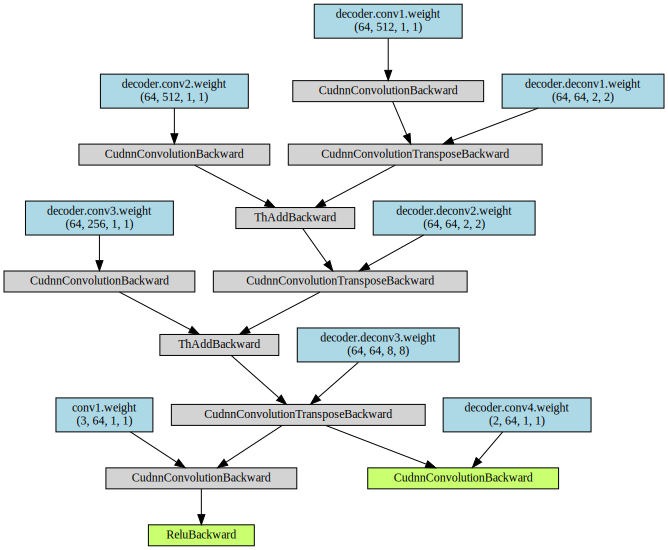

In [7]:
# visualize model

from torchviz import make_dot
inputs = next(iter(dataset))
src = inputs[0].unsqueeze(0).cuda()
make_dot(model(src), params=dict(model.named_parameters()))

In [8]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.TRAIN.LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

In [9]:
total_step = len(train_loader)
inc = int(total_step / 16)
for epoch in range(1):
    
    scheduler.step()
    
    # Training
    model.train()
    for i, (src, binary, instance) in enumerate(train_loader):
        # send to gpu
        src = src.cuda()
        binary = binary.cuda()
        instance = instance.cuda()
        
        # Forward pass
        total_loss, binary_seg_loss, disc_loss, _, _ = model.compute_loss(src, binary, instance)
        
        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if (i+1) % inc == 0:
            total_loss = total_loss.cpu().item()
            binary_seg_loss = binary_seg_loss.cpu().item()
            disc_loss = disc_loss.cpu().item()
            print ('Epoch [{}/{}], Step [{}/{}], Total Loss: {:.4f}, Binary Loss: {:.4f}, Disc Loss: {:.4f}' 
                   .format(epoch+1, CFG.TRAIN.EPOCHS, i+1, total_step, total_loss, binary_seg_loss, disc_loss))


Epoch [1/1000], Step [22/363], Total Loss: 0.5856, Binary Loss: 0.4831, Disc Loss: 0.8247
Epoch [1/1000], Step [44/363], Total Loss: 0.1688, Binary Loss: 0.1418, Disc Loss: 0.2319
Epoch [1/1000], Step [66/363], Total Loss: 0.1011, Binary Loss: 0.0998, Disc Loss: 0.1041
Epoch [1/1000], Step [88/363], Total Loss: 0.1233, Binary Loss: 0.0985, Disc Loss: 0.1811
Epoch [1/1000], Step [110/363], Total Loss: 0.0972, Binary Loss: 0.1035, Disc Loss: 0.0826
Epoch [1/1000], Step [132/363], Total Loss: 0.0809, Binary Loss: 0.0980, Disc Loss: 0.0409
Epoch [1/1000], Step [154/363], Total Loss: 0.0852, Binary Loss: 0.0934, Disc Loss: 0.0661
Epoch [1/1000], Step [176/363], Total Loss: 0.0846, Binary Loss: 0.1005, Disc Loss: 0.0474
Epoch [1/1000], Step [198/363], Total Loss: 0.0775, Binary Loss: 0.0961, Disc Loss: 0.0340
Epoch [1/1000], Step [220/363], Total Loss: 0.0793, Binary Loss: 0.0961, Disc Loss: 0.0400
Epoch [1/1000], Step [242/363], Total Loss: 0.0729, Binary Loss: 0.0899, Disc Loss: 0.0332
Epo

Debugging:

- binary loss seems to function
- discriminatory loss seems to work weirdly...

### Validation:


In [10]:
# load from saved state:

checkpoint = torch.load('../model/saved_model/lanenet_0.pth')
model.load_state_dict(checkpoint['model_state_dict'])

In [11]:
def calculate_binary_accuracy(logits, label):
    
    # input logits are separated in two class
    # check which class scored highest
    binary_prob = F.softmax(logits, dim=1)
    out = binary_prob.argmax(1)  # which class scored the highest?

    # Get indices where label
    lane_indices = (binary == 1).nonzero()  # white pixels are 1
    
    # To numpy for cpu calculation
    out = out.cpu().numpy()
    lane_indices = lane_indices.cpu().numpy()
    masked_out = np.take(out, lane_indices)

    correct = np.count_nonzero(masked_out)
    accuracy = correct / len(masked_out)
    
    return accuracy

In [12]:
# Validation Data
total_step = len(train_loader)
inc = int(total_step / 16)
for epoch in range(1):
    model.eval()
    for i, (src, binary, instance) in enumerate(val_loader):

        # send to gpu
        src = src.cuda()
        binary = binary.cuda()
        instance = instance.cuda()

        # Forward pass
        with torch.no_grad():
            _, _, _, binary_logits, pix_embeddings = model.compute_loss(src, binary, instance)

        # Calculate accuracy
        accuracy = calculate_binary_accuracy(binary_logits, binary)
        print(accuracy)
        
        
        #early break
        break

0.0
